# Main Diffusion Script
### Imports

In [1]:
try: 
    import librosa
except:
    !pip install librosa
try:
    from audio_diffusion_pytorch import DiffusionModel, UNetV0, LTPlugin, VDiffusion, VSampler
except:
    !pip install audio-diffusion-pytorch
try: 
    import a_unet
except:
    !pip install a_unet


#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))

# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
from audio_diffusion_pytorch import DiffusionModel, UNetV0, LTPlugin, VDiffusion, VSampler

from a_unet import TimeConditioningPlugin, ClassifierFreeGuidancePlugin
from a_unet.apex import XUNet, XBlock, ResnetItem as R, AttentionItem as A, CrossAttentionItem as C, ModulationItem as M, SkipCat

# Utils
import numpy as np
from numpy import ndarray
import logging
from typing import Sequence, Optional, Callable


# Base Scripts
from Libraries.Utils import *
from MainScripts.Conf import conf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 403.7/403.7 kB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 122.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 134.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.5/252.5 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 77.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 13.1 MB/s eta 0:00:00


### Config

General

In [11]:
remote_kernel: bool = True #Set to true if using a remote Kernel changes the file structure
model_name: str = "diffusion_full_v15"
training_data_name: str = "training_full_mel"
full_model_path: str = path_to_remote_path("{}/{}".format(conf["paths"].model_path, model_name + ".pth"), remote_kernel)

Logging

In [12]:
logging_level: int = LIGHT_DEBUG
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

Training Params

In [13]:
device: str = "cuda" if torch.cuda.is_available() else "cpu"
n_training_samples: int = 5600
n_validation_samples: int = 50
batch_size: int = 128
tensor_dim: list = [batch_size, 128, 576] #B, C, H = Batch, Freq bins, Time domain

learning_rate: float = 5e-4
epochs: int = 300
restart_training: bool = True
checkpoint_freq: int = 10

### Data Loading

In [14]:
file: ndarray = load_training_data(path_to_remote_path("{}/{}".format(conf["paths"].data_path, training_data_name + ".npy"), remote_kernel))
data_loader = create_dataloader(Audio_Data(file[:n_training_samples]), batch_size)
validation_dataloader = create_dataloader(Audio_Data(file[-n_validation_samples:]), batch_size)
logger.info(f"Data loaded with shape: {file.shape}")

2025-06-02 06:50:29,619 - LIGHT_DEBUG - Ndarray loaded from Data/training_full_mel.npy of shape: (5906, 128, 576)
2025-06-02 06:50:30,204 - INFO - Data loaded with shape: (5906, 128, 576)


### Setup

Model Creation

In [15]:
def UNet(dim: int, in_channels: int, channels: Sequence[int], factors: Sequence[int], items: Sequence[int], attentions: Sequence[int], cross_attentions: Sequence[int], attention_features: int, attention_heads: int, embedding_features: Optional[int] = None, skip_t: Callable = SkipCat, resnet_groups: int = 8, modulation_features: int = 1024, embedding_max_length: int = 0, use_classifier_free_guidance: bool = False, out_channels: Optional[int] = None):
    # Check lengths
    num_layers = len(channels)
    sequences = (channels, factors, items, attentions, cross_attentions)
    assert all(len(sequence) == num_layers for sequence in sequences)
    UNet = TimeConditioningPlugin(XUNet)
    if use_classifier_free_guidance:
        UNet = ClassifierFreeGuidancePlugin(UNet, embedding_max_length)

    return UNet(
        dim=dim,
        in_channels=in_channels,
        out_channels=out_channels,
        blocks=[
            XBlock(
                channels=channels,
                factor=factor,
                items=([R, M] + [A] * n_att + [C] * n_cross) * n_items,
            ) for channels, factor, n_items, n_att, n_cross in zip(*sequences)
        ],
        skip_t=skip_t,
        attention_features=attention_features,
        attention_heads=attention_heads,
        embedding_features=embedding_features,
        modulation_features=modulation_features,
        resnet_groups=resnet_groups
    )

In [16]:
u_net = UNet
u_net = DiffusionModel(
    net_t=u_net,
    dim=1,
    in_channels=128,
    channels=[128, 256, 512, 1024],
    factors=[2, 2, 2, 2],
    items=[2, 2, 2, 2],
    attentions=[0, 0, 0, 1],
    cross_attentions=[1, 1, 1, 1],
    attention_features=64,
    attention_heads=8,
    embedding_features=768,
    use_classifier_free_guidance=False,
    diffusion_t = VDiffusion,
    sampler_t = VSampler,
)

In [17]:
u_net = UNetV0
u_net = DiffusionModel(
    net_t=u_net,
    in_channels=128,
    channels=[128, 256, 512, 512, 1024, 1024, 1024],
    factors=[1, 1, 2, 2, 2, 2, 2],
    items=[1, 2, 2, 2, 2, 2, 2],
    attentions=[0, 0, 0, 1, 1, 0, 0],
    attention_features=256,
    attention_heads=8,
    diffusion_t=VDiffusion,
    sampler_t=VSampler,
    dim=1
).to(device)


Model Loading

In [18]:
optimizer = optim.AdamW(u_net.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
start_epoch: int = 0
if os.path.exists(full_model_path):
    model = torch.load(full_model_path, map_location=device)
    u_net.load_state_dict(model["model"])
    if not restart_training:
        optimizer.load_state_dict(model["optim"])
        scheduler.load_state_dict(model["scheduler"])
        start_epoch = model.get("epoch", 0)
    logger.info(f"Model {model_name} loaded with {count_parameters(u_net)} Parameters")
else: 
    logger.info(f"Model {model_name} created with {count_parameters(u_net)} Parameters")

2025-06-02 06:50:46,765 - INFO - Model diffusion_full_v15 created with ~196.7M Parameters


Initiate Trainer

In [19]:
trainer = Trainer(u_net, optimizer, scheduler, device, n_dims=1)

### Training

2025-06-02 06:51:00,429 - INFO - Training started on cuda


2025-06-02 06:51:21,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.387 Min/Max params: -2.379, 2.672


2025-06-02 06:51:21,238 - INFO - Epoch 001: Avg. Loss: 4.60068e-01 Avg. val. Loss: 5.03787e-01 Remaining Time: 01h 43min 39s LR: 4.90000e-04 


2025-06-02 06:51:39,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.367 Min/Max params: -2.380, 2.670


2025-06-02 06:51:39,622 - INFO - Epoch 002: Avg. Loss: 4.05472e-01 Avg. val. Loss: 4.88741e-01 Remaining Time: 01h 37min 18s LR: 4.80200e-04 


2025-06-02 06:52:16,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.345 Min/Max params: -2.380, 2.667


2025-06-02 06:52:16,669 - INFO - Epoch 003: Avg. Loss: 3.78226e-01 Avg. val. Loss: 3.77045e-01 Remaining Time: 02h 05min 46s LR: 4.70596e-04 


2025-06-02 06:52:39,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.344 Min/Max params: -2.379, 2.664


2025-06-02 06:52:39,379 - INFO - Epoch 004: Avg. Loss: 3.50807e-01 Avg. val. Loss: 2.88584e-01 Remaining Time: 02h 02min 01s LR: 4.61184e-04 


2025-06-02 06:52:57,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.314 Min/Max params: -2.379, 2.663


2025-06-02 06:52:57,672 - INFO - Epoch 005: Avg. Loss: 3.09555e-01 Avg. val. Loss: 3.05050e-01 Remaining Time: 01h 55min 16s LR: 4.51960e-04 


2025-06-02 06:53:19,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.252 Min/Max params: -2.379, 2.663


2025-06-02 06:53:19,996 - INFO - Epoch 006: Avg. Loss: 2.64870e-01 Avg. val. Loss: 1.76168e-01 Remaining Time: 01h 53min 58s LR: 4.42921e-04 


2025-06-02 06:53:42,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.161 Min/Max params: -2.380, 2.665


2025-06-02 06:53:42,163 - INFO - Epoch 007: Avg. Loss: 2.22774e-01 Avg. val. Loss: 2.27264e-01 Remaining Time: 01h 52min 49s LR: 4.34063e-04 


2025-06-02 06:54:04,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.162 Min/Max params: -2.380, 2.665


2025-06-02 06:54:04,536 - INFO - Epoch 008: Avg. Loss: 1.97453e-01 Avg. val. Loss: 2.11097e-01 Remaining Time: 01h 51min 59s LR: 4.25382e-04 


2025-06-02 06:54:24,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.153 Min/Max params: -2.380, 2.665


2025-06-02 06:54:24,699 - INFO - Epoch 009: Avg. Loss: 1.80374e-01 Avg. val. Loss: 1.79329e-01 Remaining Time: 01h 50min 04s LR: 4.16874e-04 


2025-06-02 06:54:47,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.142 Min/Max params: -2.380, 2.665


2025-06-02 06:54:48,120 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-06-02 06:54:48,127 - LIGHT_DEBUG - Normalized to range: [-1,1]


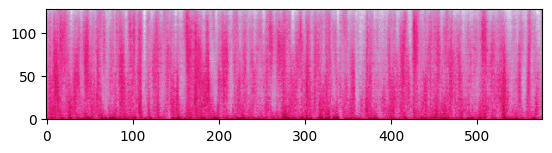

2025-06-02 06:54:48,215 - LIGHT_DEBUG - Normalized to range: [-1,1]


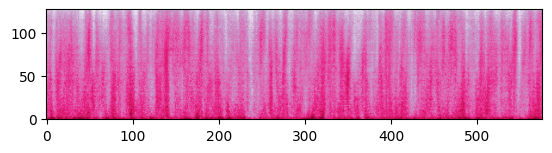

2025-06-02 06:54:48,302 - INFO - Epoch 010: Avg. Loss: 1.66874e-01 Avg. val. Loss: 1.86107e-01 Remaining Time: 01h 50min 07s LR: 4.08536e-04 
2025-06-02 06:54:50,595 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_full_v15_epoch_010.pth


2025-06-02 06:55:15,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.131 Min/Max params: -2.380, 2.665


2025-06-02 06:55:15,412 - INFO - Epoch 011: Avg. Loss: 1.58071e-01 Avg. val. Loss: 1.91857e-01 Remaining Time: 01h 50min 38s LR: 4.00366e-04 


2025-06-02 06:55:33,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.117 Min/Max params: -2.379, 2.665


2025-06-02 06:55:33,396 - INFO - Epoch 012: Avg. Loss: 1.52104e-01 Avg. val. Loss: 1.42455e-01 Remaining Time: 01h 48min 15s LR: 3.92358e-04 


2025-06-02 06:55:54,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.107 Min/Max params: -2.379, 2.665


2025-06-02 06:55:54,817 - INFO - Epoch 013: Avg. Loss: 1.44226e-01 Avg. val. Loss: 1.66276e-01 Remaining Time: 01h 47min 28s LR: 3.84511e-04 


2025-06-02 06:56:16,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.110 Min/Max params: -2.380, 2.665


2025-06-02 06:56:17,045 - INFO - Epoch 014: Avg. Loss: 1.38985e-01 Avg. val. Loss: 1.64838e-01 Remaining Time: 01h 47min 00s LR: 3.76821e-04 


2025-06-02 06:56:37,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.121 Min/Max params: -2.379, 2.665


2025-06-02 06:56:37,768 - INFO - Epoch 015: Avg. Loss: 1.35732e-01 Avg. val. Loss: 1.14064e-01 Remaining Time: 01h 46min 05s LR: 3.69285e-04 


2025-06-02 06:56:59,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.126 Min/Max params: -2.379, 2.665


2025-06-02 06:56:59,831 - INFO - Epoch 016: Avg. Loss: 1.37599e-01 Avg. val. Loss: 1.20470e-01 Remaining Time: 01h 45min 38s LR: 3.61899e-04 


2025-06-02 06:57:23,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.123 Min/Max params: -2.379, 2.665


2025-06-02 06:57:23,993 - INFO - Epoch 017: Avg. Loss: 1.32544e-01 Avg. val. Loss: 1.86139e-01 Remaining Time: 01h 45min 46s LR: 3.54661e-04 


2025-06-02 06:57:44,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.127 Min/Max params: -2.379, 2.664


2025-06-02 06:57:44,919 - INFO - Epoch 018: Avg. Loss: 1.32073e-01 Avg. val. Loss: 1.32551e-01 Remaining Time: 01h 45min 00s LR: 3.47568e-04 


2025-06-02 06:57:52,000 - LIGHT_DEBUG - Batch 011/044 Loss: 0.100 Min/Max params: -2.379, 2.665

In [ ]:
train_loss, val_loss = trainer.train(train_dataset=data_loader,
            val_dataset=validation_dataloader,
            n_epochs=epochs,
            full_model_path=full_model_path,
            checkpoint_freq=checkpoint_freq,
            patience=-1,
            gradient_clip_norm=None,
            gradient_clip_val=None,
            sample_freq=10,
            #use_embed=False
            )
scatter_plot(train_loss)
scatter_plot(val_loss)

Save Model Architecture

In [12]:
trainer.save_architecture(tensor_dim, path_to_remote_path("{}/{}".format(conf["paths"].result_path, model_name + ".pt"), remote_kernel))

/usr/local/lib/python3.11/dist-packages/einops/packing.py:148: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  lengths_of_composed_axes: List[int] = [-1 if -1 in p_shape else prod(p_shape) for p_shape in packed_shapes]
/usr/local/lib/python3.11/dist-packages/einops/packing.py:150: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  n_unknown_composed_axes = sum(int(x == -1) for x in lengths_of_composed_axes)


### Sample

2025-06-02 06:30:40,823 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-06-02 06:30:40,829 - LIGHT_DEBUG - Normalized to range: [-1,1]


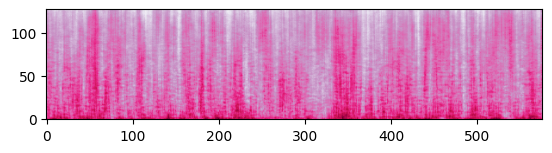

2025-06-02 06:30:40,946 - LIGHT_DEBUG - Normalized to range: [-1,1]


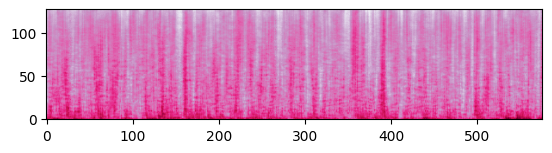

2025-06-02 06:30:41,042 - LIGHT_DEBUG - Normalized to range: [-1,1]


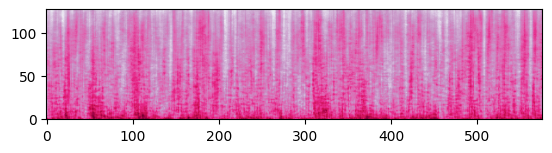

2025-06-02 06:30:41,126 - LIGHT_DEBUG - Normalized to range: [-1,1]


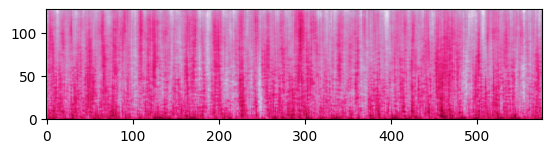

2025-06-02 06:30:41,214 - LIGHT_DEBUG - Normalized to range: [-1,1]


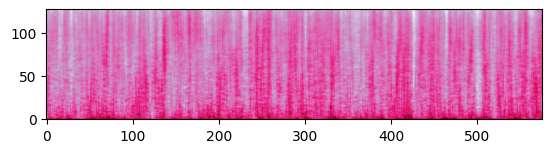

2025-06-02 06:30:41,299 - LIGHT_DEBUG - Normalized to range: [-1,1]


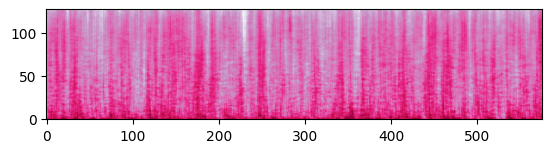

2025-06-02 06:30:41,381 - LIGHT_DEBUG - Normalized to range: [-1,1]


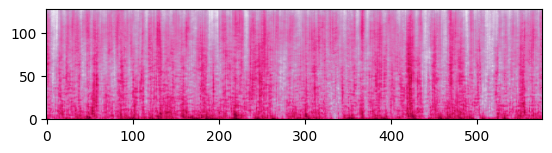

2025-06-02 06:30:41,477 - LIGHT_DEBUG - Normalized to range: [-1,1]


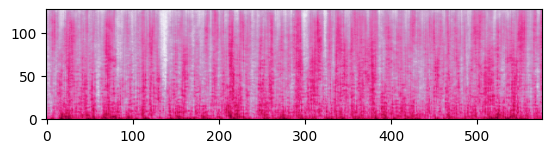

In [9]:
samples = trainer.sample(8, tensor_dim, 100, True)

Save Samples

In [14]:
trainer.save_samples(samples, path_to_remote_path("{}/{}".format(conf["paths"].result_path, "model_result"), remote_kernel))

2025-06-01 19:17:45,035 - LIGHT_DEBUG - Unnormalized to range: [-50,50]
2025-06-01 19:17:45,036 - LIGHT_DEBUG - Started GL
2025-06-01 19:17:58,353 - LIGHT_DEBUG - Normalized to range: [-0.99999,0.99999]
2025-06-01 19:17:58,354 - LIGHT_DEBUG - Reconstructed audio: (165600,)
2025-06-01 19:17:58,355 - LIGHT_DEBUG - Normalized to range: [-0.99999,0.99999]
2025-06-01 19:17:58,368 - LIGHT_DEBUG - Saved file to:Results/model_result_00.wav
2025-06-01 19:17:58,369 - LIGHT_DEBUG - Unnormalized to range: [-50,50]
2025-06-01 19:17:58,369 - LIGHT_DEBUG - Started GL
2025-06-01 19:17:58,604 - LIGHT_DEBUG - Normalized to range: [-0.99999,0.99999]
2025-06-01 19:17:58,604 - LIGHT_DEBUG - Reconstructed audio: (165600,)
2025-06-01 19:17:58,605 - LIGHT_DEBUG - Normalized to range: [-0.99999,0.99999]
2025-06-01 19:17:58,618 - LIGHT_DEBUG - Saved file to:Results/model_result_01.wav
2025-06-01 19:17:58,619 - LIGHT_DEBUG - Unnormalized to range: [-50,50]
2025-06-01 19:17:58,619 - LIGHT_DEBUG - Started GL
2025-

Evaluate

In [10]:
trainer.get_audio_metrics(samples, file)

2025-06-02 06:30:53,439 - LIGHT_DEBUG - Started GL
2025-06-02 06:31:05,811 - LIGHT_DEBUG - Normalized to range: [-0.99999,0.99999]
2025-06-02 06:31:05,811 - LIGHT_DEBUG - Reconstructed audio: (165600,)
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=576
  warnings.warn(
2025-06-02 06:31:06,774 - LIGHT_DEBUG - Started GL
2025-06-02 06:31:07,001 - LIGHT_DEBUG - Normalized to range: [-0.99999,0.99999]
2025-06-02 06:31:07,002 - LIGHT_DEBUG - Reconstructed audio: (165600,)
2025-06-02 06:31:07,010 - LIGHT_DEBUG - Started GL
2025-06-02 06:31:07,236 - LIGHT_DEBUG - Normalized to range: [-0.99999,0.99999]
2025-06-02 06:31:07,236 - LIGHT_DEBUG - Reconstructed audio: (165600,)
2025-06-02 06:31:07,245 - LIGHT_DEBUG - Started GL
2025-06-02 06:31:07,478 - LIGHT_DEBUG - Normalized to range: [-0.99999,0.99999]
2025-06-02 06:31:07,479 - LIGHT_DEBUG - Reconstructed audio: (165600,)
2025-06-02 06:31:07,487 - LIGHT_DEBUG

Spectral Convergence Samples/Real: 11.805, 7.797 Spectral Centroid Samples/Real: 4368.292 Hz, 2604.709 Hz
